# 1. Importation des Bibliothèques et du Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv(r"E:\projet morocco\results.csv")

In [5]:
print("Aperçu des données :")
display(df.head())

Aperçu des données :


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [6]:
print("\nInformations sur le dataset :")
print(df.info())


Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48891 entries, 0 to 48890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        48891 non-null  object
 1   home_team   48891 non-null  object
 2   away_team   48891 non-null  object
 3   home_score  48891 non-null  int64 
 4   away_score  48891 non-null  int64 
 5   tournament  48891 non-null  object
 6   city        48891 non-null  object
 7   country     48891 non-null  object
 8   neutral     48891 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 3.0+ MB
None


In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df_recent = df[df['date'].dt.year >= 2015].copy()

# 2. Préparation des données (Filtre CAF & Era Moderne)

In [11]:
pays_caf = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 
    'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Comoros', 
    'Congo', 'DR Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 
    'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 
    'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 
    'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 
    'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 
    'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 
    'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

In [15]:
df_can = df_recent[df_recent['home_team'].isin(pays_caf) | df_recent['away_team'].isin(pays_caf)].copy()

In [17]:
print(f"Nombre de matchs filtrés pour l'Afrique : {len(df_can)}")

Nombre de matchs filtrés pour l'Afrique : 2608


In [34]:
print(f"Données originales : {len(df)} lignes")
print(f"Après filtrage : {len(df_can)} lignes")
print(f"Réduction de {(1 - len(df_can)/len(df))*100:.2f}% du volume de données pour cibler la pertinence.")

Données originales : 48891 lignes
Après filtrage : 2608 lignes
Réduction de 94.67% du volume de données pour cibler la pertinence.


# 3. Feature Engineering : Création des moyennes mobiles (Rolling Averages)

In [20]:
df_can['total_goals'] = df_can['home_score'] + df_can['away_score']


In [21]:
df_can['home_win'] = (df_can['home_score'] > df_can['away_score']).astype(int)

In [24]:
df_can['morocco_home'] = (df_can['home_team'] == 'Morocco').astype(int)

# 4. Entraînement du modèle Random Forest

In [43]:

# On utilise une moyenne mobile (rolling mean)
df_can = df_can.sort_values('date')

# Moyenne de buts marqués à domicile lors des matchs précédents
df_can['home_team_avg_goals'] = df_can.groupby('home_team')['home_score'].transform(lambda x: x.shift().expanding().mean())
df_can['away_team_avg_goals'] = df_can.groupby('away_team')['away_score'].transform(lambda x: x.shift().expanding().mean())

# Remplir les cases vides (au début de l'historique) par 0
df_can = df_can.fillna(0)

# 2. Nouvelles Features (données disponibles AVANT le match)
X = df_can[['home_team_avg_goals', 'away_team_avg_goals', 'morocco_home']]
y = df_can['home_win']

# 3. Ré-entraîner le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

new_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Nouvelle précision (réaliste) : {new_accuracy:.2%}")

Nouvelle précision (réaliste) : 55.94%


In [44]:
# On récupère les dernières stats moyennes du Maroc et du Cameroun
stats_maroc = df_can[df_can['home_team'] == 'Morocco']['home_team_avg_goals'].iloc[-1]
stats_cameroun = df_can[df_can['away_team'] == 'Cameroon']['away_team_avg_goals'].iloc[-1]

# On crée le match (Maroc est à domicile = 1)
match_quart_finale = pd.DataFrame([[stats_maroc, stats_cameroun, 1]], 
                                  columns=['home_team_avg_goals', 'away_team_avg_goals', 'morocco_home'])

# Prédiction
proba = model.predict_proba(match_quart_finale)
print(f"Probabilité de victoire du Maroc : {proba[0][1]:.2%}")

Probabilité de victoire du Maroc : 88.00%


# 7. Visualisations

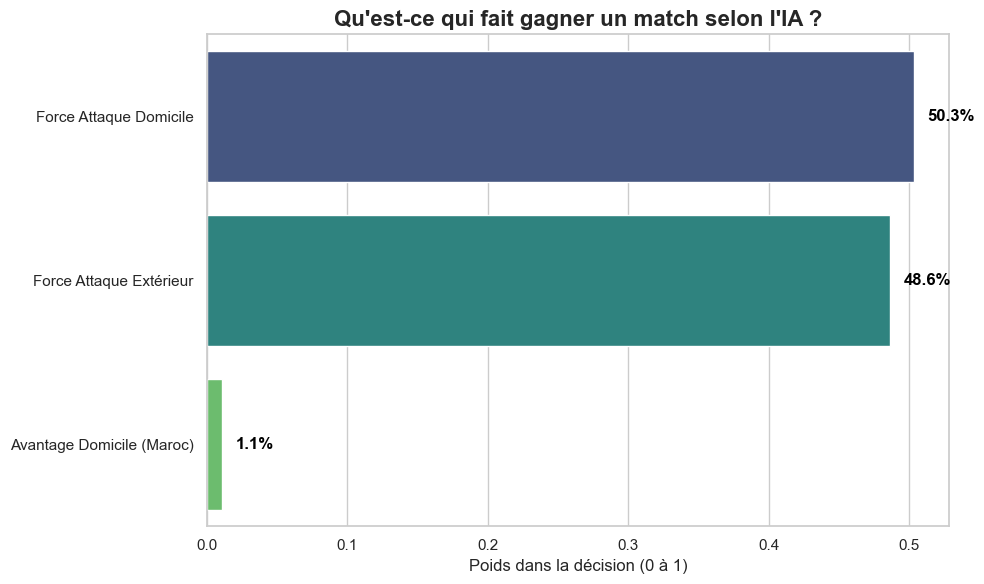

In [46]:


# 1. Préparation des données (comme avant)
importances = model.feature_importances_
feature_names = ['Force Attaque Domicile', 'Force Attaque Extérieur', 'Avantage Domicile (Maroc)']
df_imp = pd.DataFrame({'Variable': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False)

# 2. Le Graphique corrigé
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# CORRECTION ICI : on ajoute hue='Variable' et legend=False
plot = sns.barplot(
    x='Importance', 
    y='Variable', 
    data=df_imp, 
    hue='Variable',  # On dit que la couleur dépend de la variable
    palette='viridis', 
    legend=False     # On cache la légende car elle est inutile ici
)

# Ajouter les pourcentages au bout des barres
for i, v in enumerate(df_imp['Importance']):
    plot.text(v + 0.01, i, f"{v:.1%}", color='black', va='center', fontweight='bold')

plt.title("Qu'est-ce qui fait gagner un match selon l'IA ?", fontsize=16, fontweight='bold')
plt.xlabel("Poids dans la décision (0 à 1)")
plt.ylabel("")
plt.tight_layout()


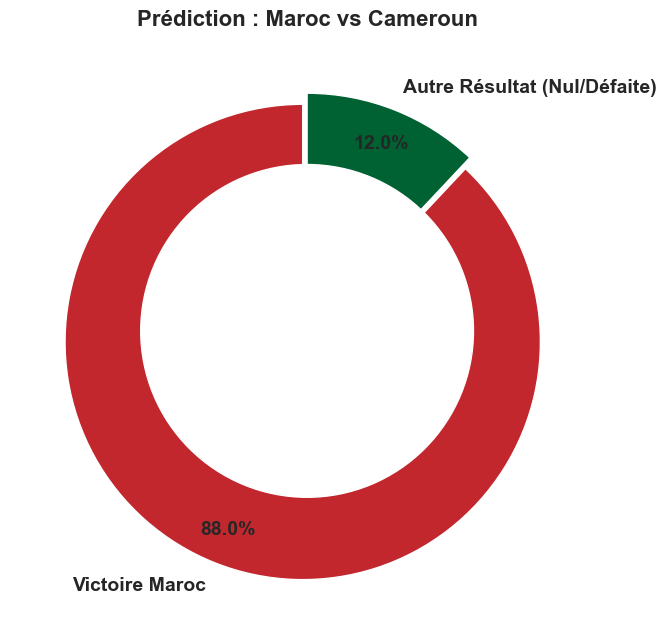

In [48]:
# Données de la prédiction (Maroc vs Cameroun)
labels = ['Victoire Maroc', 'Autre Résultat (Nul/Défaite)']
sizes = [88, 12] # Ton résultat
colors = ['#c1272d', '#006233'] # Rouge et Vert (Couleurs du Maroc)
explode = (0.05, 0) # Pour détacher légèrement la part du Maroc

plt.figure(figsize=(7, 7))
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode, textprops={'fontsize': 14, 'fontweight': 'bold'})

# Dessiner un cercle blanc au milieu pour faire un "Donut"
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Prédiction : Maroc vs Cameroun", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()